In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

In [2]:
words = open('names.txt').read().splitlines()

In [3]:
# chrs = sorted(list(set([ch for word in words for ch in word])))
chrs = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
def build_dataset(words):
    block_size = 3
    X ,Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    Y = torch.tensor(Y)
    X = torch.tensor(X)
    return X,Y

In [5]:
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) 
Xdev, Ydev = build_dataset(words[n1:n2]) 
Xte, Yte = build_dataset(words[n2:]) 

In [14]:
C = torch.randn(27,20)
w1 = torch.randn(60,500)
b1 = torch.randn(500)
w2 = torch.randn(500,27)
b2 = torch.randn(27)
parameters = [C, w1, b1, w2, b2]  
for p in parameters:
    p.requires_grad = True

total_params = sum([p.nelement() for p in parameters])
total_params

44567

In [15]:
lre = torch.linspace(-3, 0, 1000); lrs = 10**lre

In [16]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(1000):

    # minibatch
    ix = torch.randint(0, Xtr.shape[0],(32,))
    
    # Forward pass
    emb = C[Xtr][ix] # 32,3,2
    h = torch.tanh((emb.view(-1, 60) @ w1) + b1)  #(32,6 @ 6,100) = (32,100)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    if (i + 1) % 100 == 0: 
        print(f"Iteration {i + 1}, Loss: {loss.item()}")
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward() 
    
    # Update
    # lr = lrs[i]
    # lr = 0.1 if i < 10000 else 0.01
    lr = 0.01 * (1 + torch.cos(torch.tensor(i / 5000 * 3.14159))) / 2
    
    for p in parameters:
        p.data +=  -lr * p.grad

    # track stats|
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

Iteration 100, Loss: 19.552906036376953
Iteration 200, Loss: 17.958847045898438
Iteration 300, Loss: 19.132564544677734
Iteration 400, Loss: 8.17078685760498
Iteration 500, Loss: 10.501323699951172


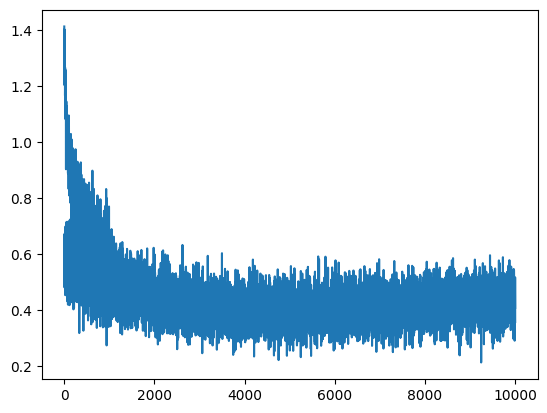

In [11]:
plt.plot(stepi,lossi)

In [20]:
emb = C[Xtr] # 32,3,2
h = torch.tanh((emb.view(-1, 60) @ w1) + b1)  #(32,6 @ 6,100) = (32,100)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(21.4475, grad_fn=<NllLossBackward0>)

In [21]:
emb = C[Xdev] # 32,3,2
h = torch.tanh((emb.view(-1, 60) @ w1) + b1)  #(32,6 @ 6,100) = (32,100)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(21.4657, grad_fn=<NllLossBackward0>)

In [ ]:
plt.scatter(C[:,0].data , C[:,1].data, s= 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = "center" , va= "center", color = "white")

In [ ]:
def sample(model, stoi, itos, block_size=3, max_len=10, seed_context=None):
    context = [0] * block_size if seed_context is None else [stoi[c] for c in seed_context][-block_size:]
    generated = []
    
    for _ in range(max_len):
        x = torch.tensor([context], dtype=torch.long)
        emb = model[0][x]  
        h = torch.tanh(emb.view(-1, 30) @ model[1] + model[2])  # w1, b1
        logits = h @ model[3] + model[4]  # w2, b2
        probs = torch.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1).item()
        generated.append(itos[ix])
        context = context[1:] + [ix]
        if ix == 0:  
            break
    
    return ''.join(generated).replace('.', '')

for _ in range(10):
    generated_text = sample(parameters, stoi, itos, block_size=3, max_len=10)
    print(generated_text)